# Compile analysis

first we list all the relevant result files

In [1]:
from astropy.time import Time, TimeDelta
import h5py
import numpy as np
import pickle
from pathlib import Path
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.style.use('dark_background')

import sorts
import pyorb
import pyant

In [2]:
HERE = Path('.').resolve()
OUTPUT = HERE / 'output' / 'russian_asat'
print(f'Using {OUTPUT} as output')

Using /home/danielk/git/antisat_analysis/projects/output/russian_asat as output


In [3]:
with open(OUTPUT / 'paths.pickle', 'rb') as fh:
    paths = paths = pickle.load(fh)

pprint(paths)

{'correlation_select': {'esr': [PosixPath('/home/danielk/git/antisat_analysis/projects/output/russian_asat/2021.11.19_esr_correlation_plots/eiscat_esr_selected_correlations.npy'),
                                PosixPath('/home/danielk/git/antisat_analysis/projects/output/russian_asat/2021.11.23_esr_correlation_plots/eiscat_esr_selected_correlations.npy'),
                                PosixPath('/home/danielk/git/antisat_analysis/projects/output/russian_asat/2021.11.25_esr_correlation_plots/eiscat_esr_selected_correlations.npy'),
                                PosixPath('/home/danielk/git/antisat_analysis/projects/output/russian_asat/2021.11.29_esr_correlation_plots/eiscat_esr_selected_correlations.npy')],
                        'uhf': [PosixPath('/home/danielk/git/antisat_analysis/projects/output/russian_asat/2021.11.23_uhf_correlation_plots/eiscat_uhf_selected_correlations.npy'),
                                PosixPath('/home/danielk/git/antisat_analysis/projects/output/russi

## Compile kosmos-1408 list

first we devide the results into 4 categores:
```
uncorrelated results
| - possible kosmos fragments
| - not kosmos fragments
correlated results
| - kosmos fragments
| - not kosmos fragments
```

To do this we need selection criteria for "possible kosmos fragments" for each campagin

In [4]:
#Structure is (lower left corner), (upper right corner)
kosmos_selection = {
    'uhf': [
        None,
        {
            't': (1.95, 2.6), 
            'r': (300, 700),
            'v': (0.2, 1.2),
        },
        None,
    ]
}

In [5]:
class Categories:
    uncorrelated_other = 0
    correlated_other = 1
    uncorrelated_kosmos = 2
    correlated_kosmos = 3
category_names = [
    'Uncorrelated background',
    'Correlated background',
    'Uncorrelated KOSMOS-1408',
    'Correlated KOSMOS-1408',
]

### Category selection
We can then select these categories, we start by loading the relevant data

In [6]:
data = {}
with h5py.File(paths['data_paths']['uhf'][1], 'r') as hf:
    for key in hf:
        data[key] = hf[key][()]
select = np.load(paths['correlation_select']['uhf'][1])
kosmos_select = np.load(paths['kosmos_correlation_select']['uhf'][1])

In [7]:
# The category identifier
category = np.full((len(data['t'],)), Categories.uncorrelated_other, dtype=int)

In [8]:
#get data
t_box = kosmos_selection['uhf'][1]['t']
r_box = kosmos_selection['uhf'][1]['r']
v_box = kosmos_selection['uhf'][1]['v']

t = (data['t'] - np.min(data['t']))/3600.0
r = data['r']
v = data['v']

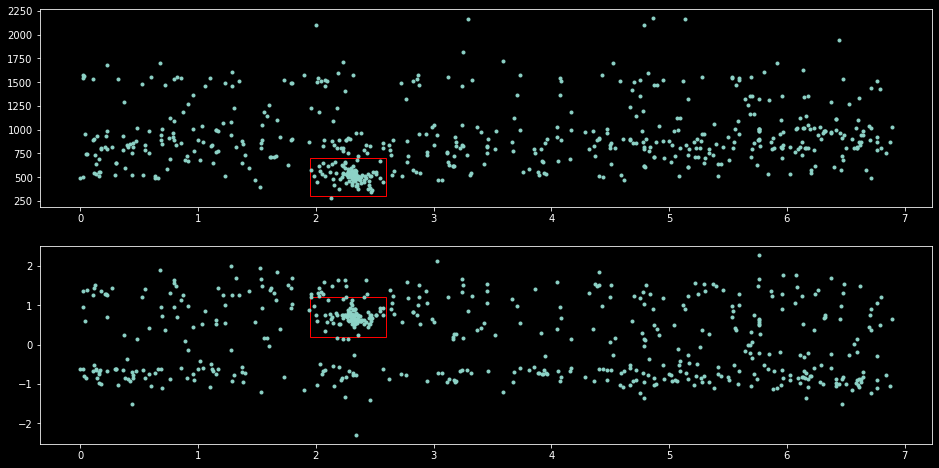

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(16,8))
axes[0].plot(t, r, '.')
rect = patches.Rectangle(
    (t_box[0], r_box[0]), 
    t_box[1] - t_box[0], 
    r_box[1] - r_box[0], 
    linewidth=1, 
    edgecolor='r', 
    facecolor='none',
)
axes[0].add_patch(rect)

axes[1].plot(t, v, '.')
rect = patches.Rectangle(
    (t_box[0], v_box[0]), 
    t_box[1] - t_box[0], 
    v_box[1] - v_box[0], 
    linewidth=1, 
    edgecolor='r', 
    facecolor='none',
)
axes[1].add_patch(rect)

In [10]:
box_selector = np.logical_and.reduce([
    t >= t_box[0], 
    t <= t_box[1],
    r >= r_box[0], 
    r <= r_box[1],
    v >= v_box[0], 
    v <= v_box[1],
])

### Assign categories

In [11]:
category[:] = Categories.uncorrelated_other
category[box_selector] = Categories.uncorrelated_kosmos
category[select] = Categories.correlated_other
category[kosmos_select] = Categories.correlated_kosmos

In [12]:
print(category)

[1 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0
 0 1 1 0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 0 0 0 1 1 1 1 0 1
 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0
 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 2 0 1 2 1 0 0 1 0 0 1 1
 1 1 0 1 0 3 2 0 1 1 2 1 0 0 0 3 1 1 1 0 2 2 1 2 1 1 0 1 2 0 0 2 0 0 2 1 1
 1 2 2 2 0 1 2 2 2 2 2 1 2 2 1 2 1 2 2 2 0 2 2 2 2 2 2 1 0 2 0 2 2 0 2 2 2
 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 1 2 2 0 2 2 2 2 3 2 2 2 1 2 2 2 2 0 2 2
 1 2 0 1 2 0 2 3 2 2 2 2 0 2 2 2 0 2 2 2 2 0 0 2 0 1 0 0 0 0 1 3 0 1 0 0 0
 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0
 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1
 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1
 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1
 0 0 1 0 0 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0
 1 1 1 0 0 1 0 0 0 0 1 1 

Text(0, 0.5, 'Detections')

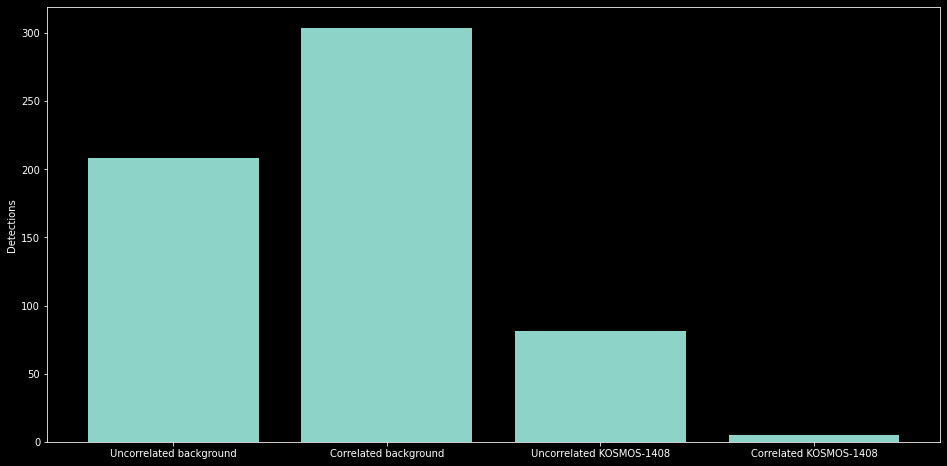

In [14]:
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(4), [np.sum(category == ind) for ind in range(4)])
ax.set_xticks(range(4), labels=category_names)
ax.set_ylabel('Detections')

In [16]:
out_categories = OUTPUT / (str(paths['dates'][1]) + '_uhf' + '_categories.npy')
np.save(out_categories, category)